
# **Introduction**
Autoencoders, a unique breed within the vast landscape of deep learning architectures, serve as the cornerstone of our project aimed at colorizing black and white images. These networks, composed of two critical halves—the encoder and the decoder—specialize in transforming input data into a reduced-dimensional representation and subsequently reconstructing it back to its original form, or as close to it as possible. Through the encoder's use of convolutional neural networks (CNNs) and downsampling, it learns a compressed essence of the data. The decoder then employs CNNs and upsampling techniques to regenerate the data from these condensed representations. The ultimate goal of a well-trained autoencoder is to produce output that mirrors the original input data, preserving the essential characteristics while potentially adding new dimensions, such as color.

# **Import necessary libraries**

This section loads all the essential Python libraries required for our image colorization project. Each library serves a specific role, ranging from handling image processing tasks to building and training deep learning models.

In [ ]:

import tensorflow as tf
import keras
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from zipfile import ZipFile
from keras import layers

import cv2
import numpy as np
from tensorflow.keras.metrics import MeanSquaredError
from skimage.metrics import structural_similarity as ssim


# **Downloading and Extracting the Dataset**


Configuring Kaggle API Access
To download datasets directly from Kaggle, we first need to set up Kaggle API access. This involves placing the kaggle.json API key file in the correct location and setting appropriate permissions.

In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d mykeysid10/image-colorization-using-gans

 85% 36.0M/42.6M [00:00<00:00, 133MB/s]
100% 42.6M/42.6M [00:00<00:00, 80.5MB/s]


In [ ]:
# extracting the compessed Dataset
data = '/content/image-colorization-using-gans.zip'

with ZipFile(data,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


# **Data Preprocessing for Image Colorization**


In this section, we prepare our dataset for the image colorization model, involving sorting filenames, resizing images, normalizing their pixel values, and creating corresponding grayscale versions. This preparation is crucial for training our model effectively.

**Sorting Filenames:** We start by defining a helper function, sorted_alphanumeric, which sorts filenames in a logical and human-understandable order. This helps in processing images sequentially.

**Setting Up and Image Processing:**

**Target Size:** All images are resized to a uniform size (SIZE = 160) for consistency.                                                                               
**Color and Grayscale Images:** We initialize two lists to store the color (RGB) and grayscale versions of the images. Using OpenCV, we read images in color, convert them to RGB (from BGR), resize, and normalize them to the range [0, 1]. We also create grayscale versions to serve as inputs to the model.

In [ ]:

# Helper function to sort filenames alphanumerically
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Define the size to resize images
SIZE = 160
color_images = []
grayscale_images = []

# Dataset directory
path = '/content/img_color_data/data'
files = os.listdir(path)
files = sorted_alphanumeric(files)

# Process files to create color and corresponding grayscale image arrays
for filename in tqdm(files):
    img_path = os.path.join(path, filename)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is not None:
        # OpenCV reads images in BGR format, so we convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize the image
        img = cv2.resize(img, (SIZE, SIZE))
        # Normalize pixel values to the range [0, 1]
        img_normalized = img.astype('float32') / 255.0
        color_images.append(img_to_array(img_normalized))

        # Convert the color image to grayscale for the model input
        grayscale = cv2.cvtColor(img_normalized, cv2.COLOR_RGB2GRAY)
        grayscale = np.expand_dims(grayscale, axis=-1)  # Add channel dimension
        grayscale_images.append(img_to_array(grayscale))

# Convert lists to numpy arrays
color_images = np.array(color_images)
grayscale_images = np.array(grayscale_images)

# Check the shapes to confirm everything is as expected
print("Color images shape:", color_images.shape)
print("Grayscale images shape:", grayscale_images.shape)


100%|██████████| 3000/3000 [00:03<00:00, 836.97it/s]


Color images shape: (3000, 160, 160, 3)
Grayscale images shape: (3000, 160, 160, 1)


### **Advanced Image Preprocessing Techniques**


In this section, we delve deeper into image preprocessing techniques aimed at enhancing the model's ability to colorize grayscale images. By applying histogram equalization and edge detection, we aim to improve the quality and detail of the images before they are fed into the neural network.

100%|██████████| 3000/3000 [00:04<00:00, 700.41it/s]


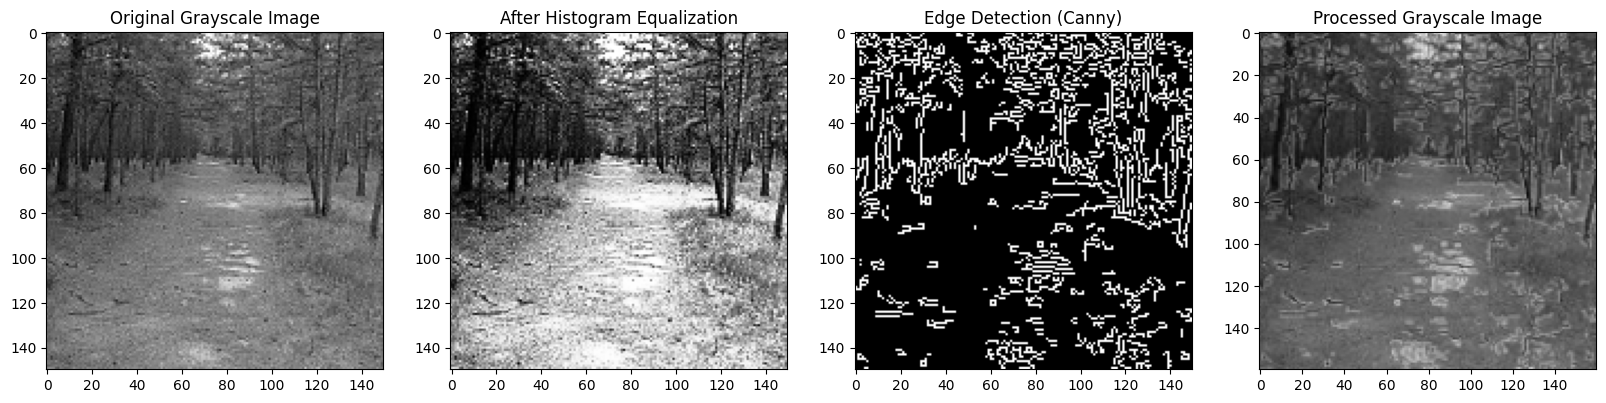

In [ ]:
# Ensure SIZE is defined
SIZE = 160

#Dataset directory
gray_path = '/content/img_color_data/data'
gray_files = os.listdir(gray_path)
gray_files = sorted_alphanumeric(gray_files)

# Initialize an empty list to store processed images
gray_img = []

# Initialize variables to store the steps of the first image for demonstration
first_original_img = None
first_img_equalized = None
first_edges = None
first_img_rgb = None

# Process each file in the directory
for i, file_name in enumerate(tqdm(gray_files)):
    file_path = os.path.join(gray_path, file_name)

    # Load grayscale image
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    if img is None:  # Skip files that can't be opened/read
        continue

    # Store the results of the first image for later demonstration
    if i == 0:
        first_original_img = img.copy()

    # Histogram Equalization
    img_equalized = cv2.equalizeHist(img)
    if i == 0:
        first_img_equalized = img_equalized.copy()

    # Edge Detection (using Canny)
    edges = cv2.Canny(img, 100, 200)
    if i == 0:
        first_edges = edges.copy()

    # Combine edges with the grayscale image to preserve edges
    img_combined = cv2.addWeighted(img, 0.8, edges, 0.2, 0)

    # Resizing image
    img_resized = cv2.resize(img_combined, (SIZE, SIZE))

    # Convert image to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    if i == 0:
        first_img_rgb = img_rgb.copy()

    # Normalize and append to list
    img_normalized = img_rgb.astype('float32') / 255.0
    gray_img.append(img_normalized)

# After processing all images, display the first image for demonstration
if first_original_img is not None:
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(first_original_img, cmap='gray')
    plt.title('Original Grayscale Image')

    plt.subplot(1, 4, 2)
    plt.imshow(first_img_equalized, cmap='gray')
    plt.title('After Histogram Equalization')

    plt.subplot(1, 4, 3)
    plt.imshow(first_edges, cmap='gray')
    plt.title('Edge Detection (Canny)')

    plt.subplot(1, 4, 4)
    plt.imshow(first_img_rgb)
    plt.title('Processed Grayscale Image')

    plt.show()
else:
    print("No images were processed.")


# **Preparing Training and Testing Sets**


Once the images have been processed, the next crucial step is to split the dataset into training and testing sets. This division allows the model to learn from a specific subset of the data (training set) and then evaluate its performance on unseen data (testing set), ensuring the model's generalizability and effectiveness.

In [ ]:
# Number of images in the dataset
num_images = len(color_images)

# Desired train/test split ratio
train_test_ratio = 0.8  # 80% for training, 20% for testing

# Calculate the split index
split_index = int(num_images * train_test_ratio)

# Slicing the dataset into training and testing sets based on the calculated index
train_gray_images = grayscale_images[:split_index]
train_color_images = color_images[:split_index]

test_gray_images = grayscale_images[split_index:]
test_color_images = color_images[split_index:]

# Print shapes to confirm
print('Train grayscale image shape:', np.array(train_gray_images).shape)
print('Train color image shape:', np.array(train_color_images).shape)
print('Test grayscale image shape:', np.array(test_gray_images).shape)
print('Test color image shape:', np.array(test_color_images).shape)

Train grayscale image shape: (2400, 160, 160, 1)
Train color image shape: (2400, 160, 160, 3)
Test grayscale image shape: (600, 160, 160, 1)
Test color image shape: (600, 160, 160, 3)


# **Building the Image Colorization Model**


Our approach to colorizing black and white images harnesses the power of autoencoders, leveraging their unique architecture that embodies both convolutional neural networks (CNNs) and the conceptual framework of encoding and decoding. At the heart of this model lies the strategic interplay between downsampling and upsampling processes, orchestrated through the encoder and decoder networks respectively.

In [ ]:
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.add(layers.Dropout(0.2))
    upsample.add(layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape=[160, 160, 1])
    d1 = down(64, (3, 3), False)(inputs)
    d2 = down(128, (3, 3), True)(d1)


    u1 = up(128, (3, 3), False)(d2)
    u1 = layers.concatenate([u1, d1])
    u2 = up(3, (3, 3), False)(u1)

    output = layers.Conv2D(3, (3, 3), strides=1, padding='same', activation='sigmoid')(u2)
    return tf.keras.Model(inputs=inputs, outputs=output)


In [ ]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 80, 80, 64)           640       ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 40, 40, 128)          74368     ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 80, 80, 128)          147584    ['sequential_1[0][0]']        
                                                                                              

This model architecture is a simplified version of a U-Net, a popular network for image-to-image translation tasks. It's designed to balance the model's complexity with its capability to generate high-quality colorized images from grayscale inputs.

# **Training the Image Colorization Model**


With the model architecture defined, the next step is to compile and train the model on our prepared dataset. Training a model involves adjusting its parameters to minimize the difference between the predicted colorized images and the actual color images in the training set. This process is guided by a loss function, optimizer, and defined metrics for performance evaluation

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])


model.fit(train_gray_images, train_color_images, epochs=60, batch_size=32, verbose=1)


Epoch 1/60
75/75 [==============================] - 191s 2s/step - loss: 0.0642 - accuracy: 0.4198
Epoch 2/60
75/75 [==============================] - 183s 2s/step - loss: 0.0596 - accuracy: 0.4408
Epoch 3/60
75/75 [==============================] - 185s 2s/step - loss: 0.0575 - accuracy: 0.4508
Epoch 4/60
75/75 [==============================] - 188s 3s/step - loss: 0.0569 - accuracy: 0.4523
Epoch 5/60
75/75 [==============================] - 186s 2s/step - loss: 0.0550 - accuracy: 0.4591
Epoch 6/60
75/75 [==============================] - 184s 2s/step - loss: 0.0546 - accuracy: 0.4600
Epoch 7/60
75/75 [==============================] - 183s 2s/step - loss: 0.0540 - accuracy: 0.4642
Epoch 8/60
75/75 [==============================] - 183s 2s/step - loss: 0.0538 - accuracy: 0.4574
Epoch 9/60
75/75 [==============================] - 182s 2s/step - loss: 0.0526 - accuracy: 0.4615
Epoch 10/60
75/75 [==============================] - 182s 2s/step - loss: 0.0525 - accuracy: 0.4602
Epoch 11/

# **Evaluating the Model's Performance**


After training the image colorization model, it's crucial to assess its performance on the test dataset. This evaluation helps in understanding how well the model generalizes to unseen data, providing insights into its effectiveness and areas for improvement.

In [ ]:
model.evaluate(test_gray_images, test_color_images)


19/19 [==============================] - 17s 841ms/step - loss: 0.0465 - accuracy: 0.4602


[0.04648583382368088, 0.46015897393226624]

### **Performance Metrics:**

Beyond the initial evaluation, we delve deeper into the model's performance by computing the Mean Squared Error (MSE) and the Peak Signal-to-Noise Ratio (PSNR) between the predicted color images and the actual color images.

In [ ]:
# Assuming you have your test dataset ready and predictions made
y_pred = model.predict(test_gray_images)
y_true = test_color_images  # Your actual color images

# Ensure the predictions and true images are in the correct format
y_pred = np.clip(y_pred, 0, 1)  # Ensure the predictions are in the range [0, 1]
y_true = np.clip(y_true, 0, 1)  # Ensure the true images are in the range [0, 1]

# Calculate Mean Squared Error
mse_metric = MeanSquaredError()
mse_metric.update_state(y_true, y_pred)
mse_result = mse_metric.result().numpy()
print(f"Mean Squared Error: {mse_result}")

# Calculate PSNR
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 * np.log10((max_pixel ** 2) / (np.mean(np.square(y_pred - y_true))))

psnr_value = psnr(y_true, y_pred)
print(f"Peak Signal-to-Noise Ratio: {psnr_value} dB")


19/19 [==============================] - 17s 842ms/step
Mean Squared Error: 0.00553478067740798
Peak Signal-to-Noise Ratio: 22.568991454400347 dB


# **Visualizing Colorization Results**



After training and evaluating the model, visualizing the colorization results provides an intuitive way to assess the model's performance. By comparing the original color images, their grayscale counterparts, and the colorized predictions side by side, we can qualitatively evaluate how effectively the model has learned to reconstruct the color details.

1/1 [==============================] - 0s 42ms/step


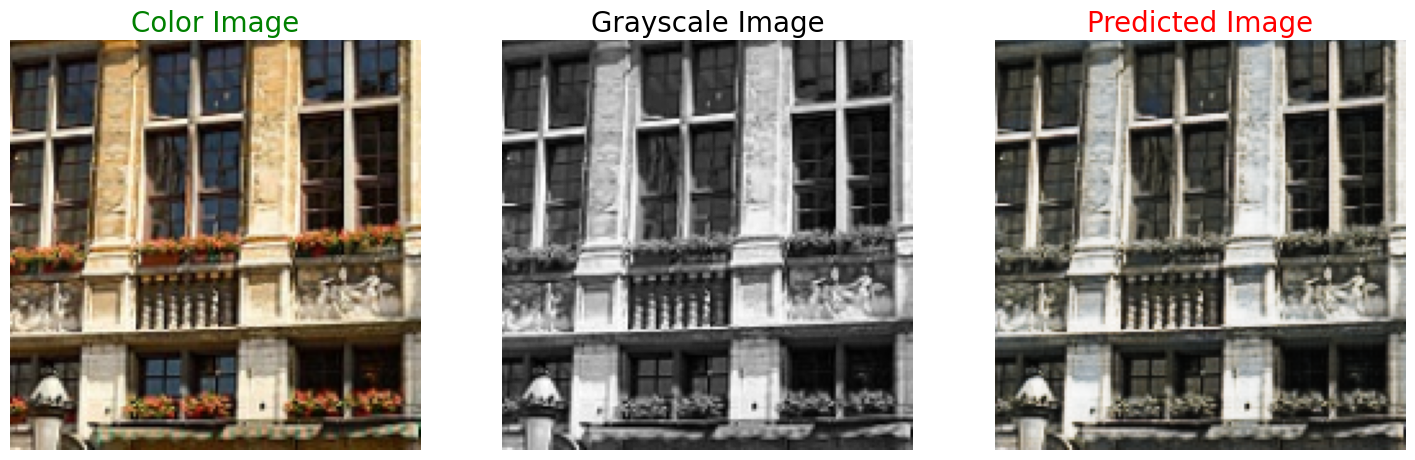

1/1 [==============================] - 0s 71ms/step


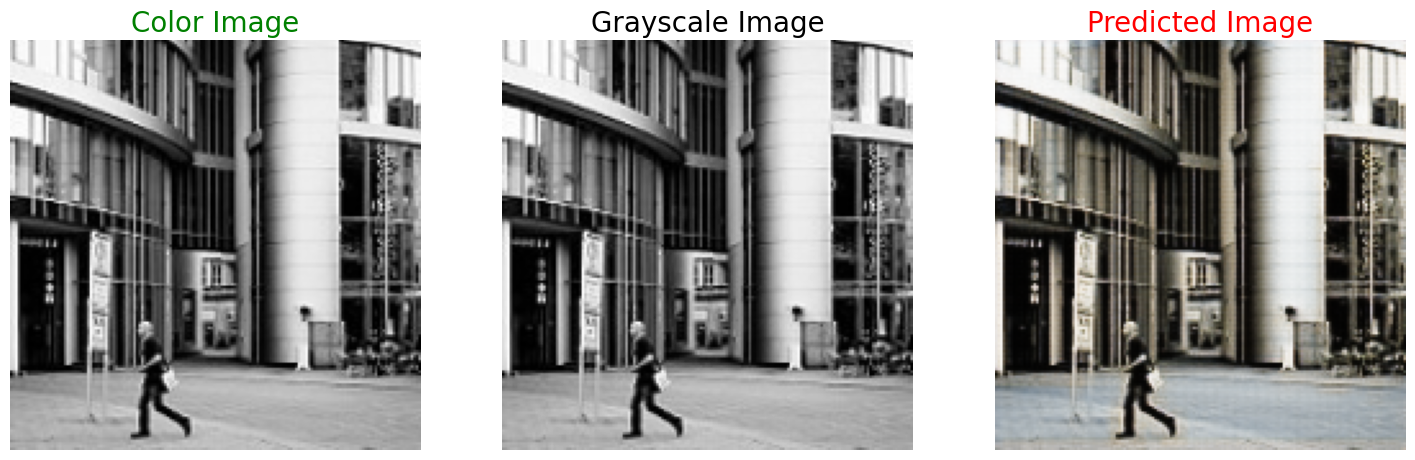

1/1 [==============================] - 0s 72ms/step


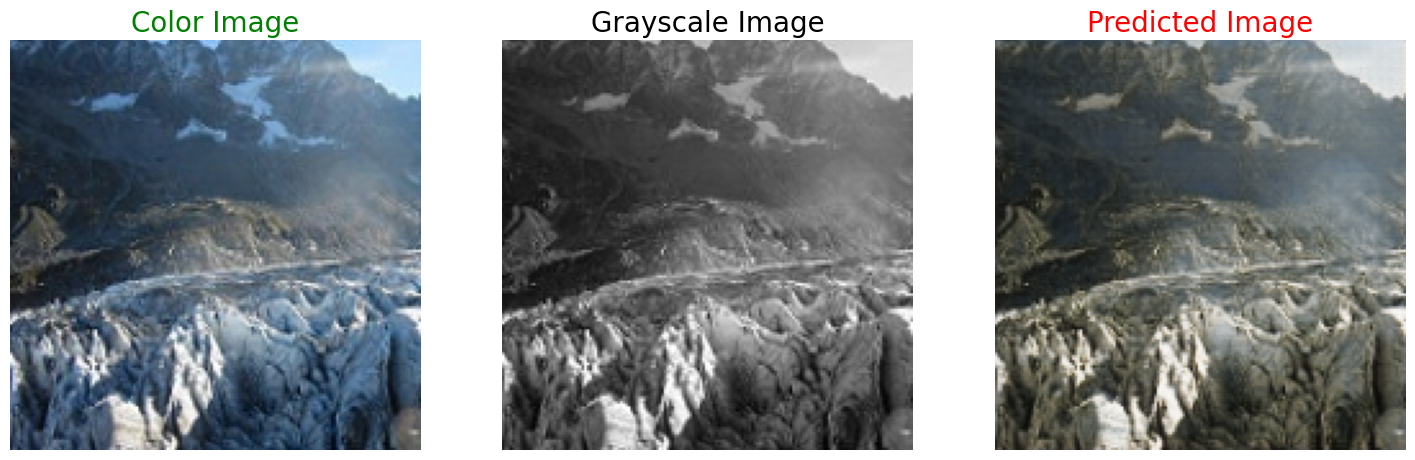

1/1 [==============================] - 0s 68ms/step


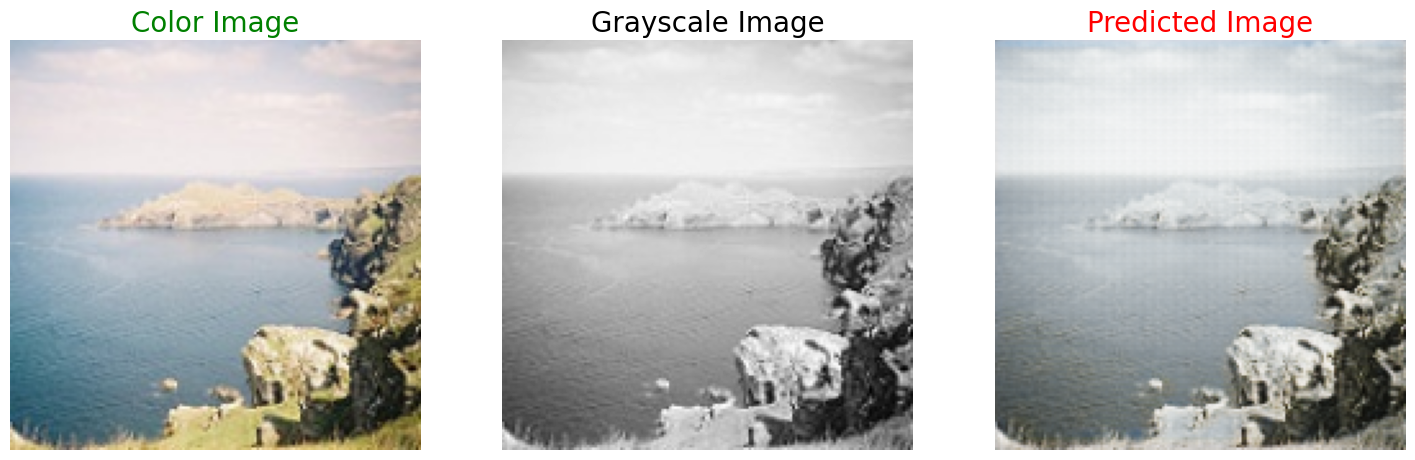

1/1 [==============================] - 0s 69ms/step


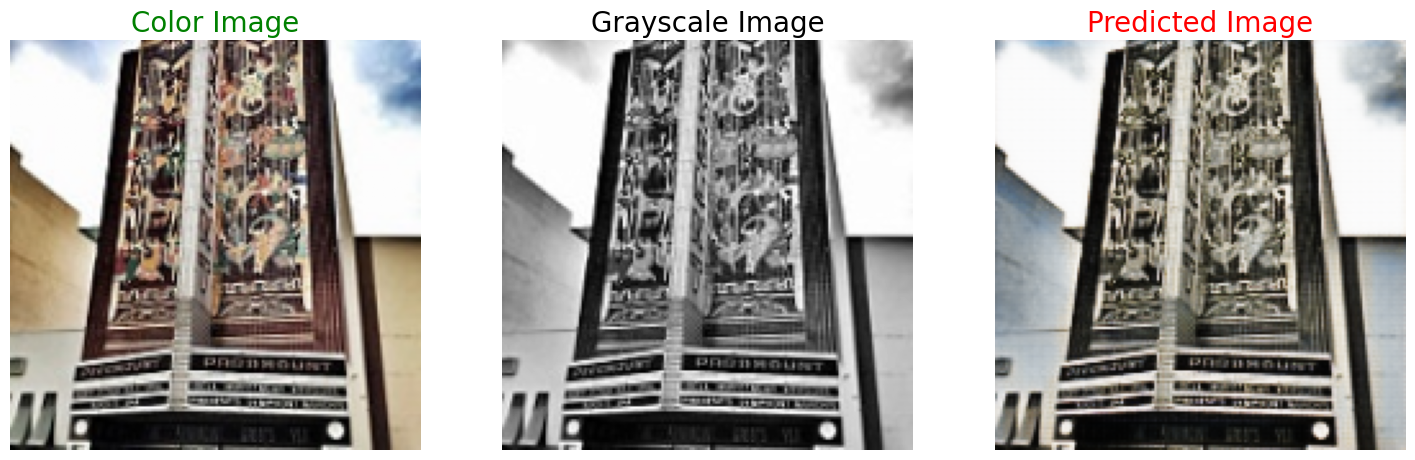

1/1 [==============================] - 0s 65ms/step


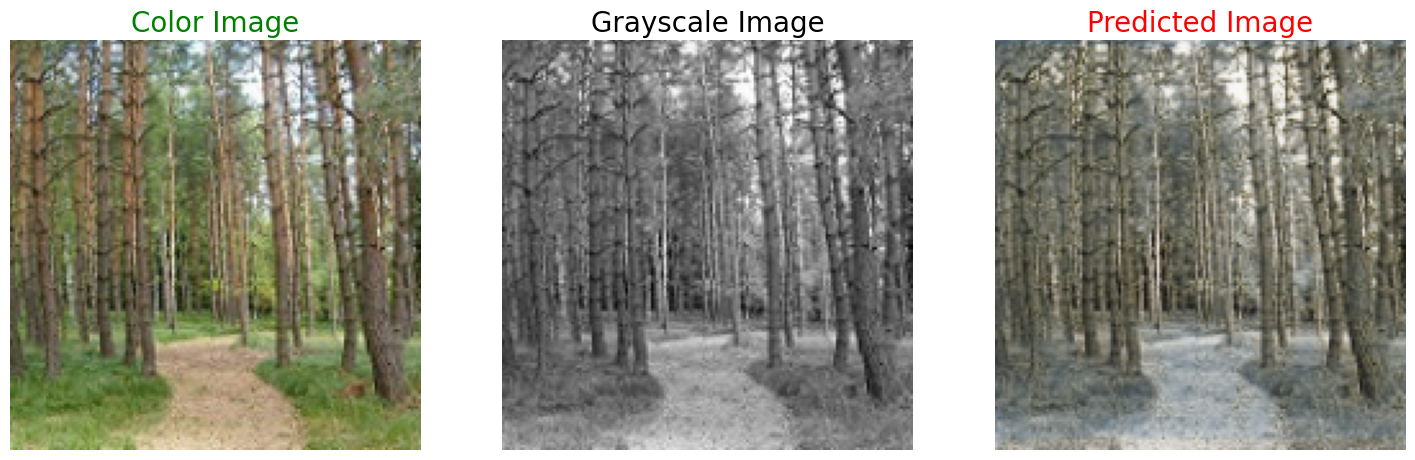

1/1 [==============================] - 0s 61ms/step


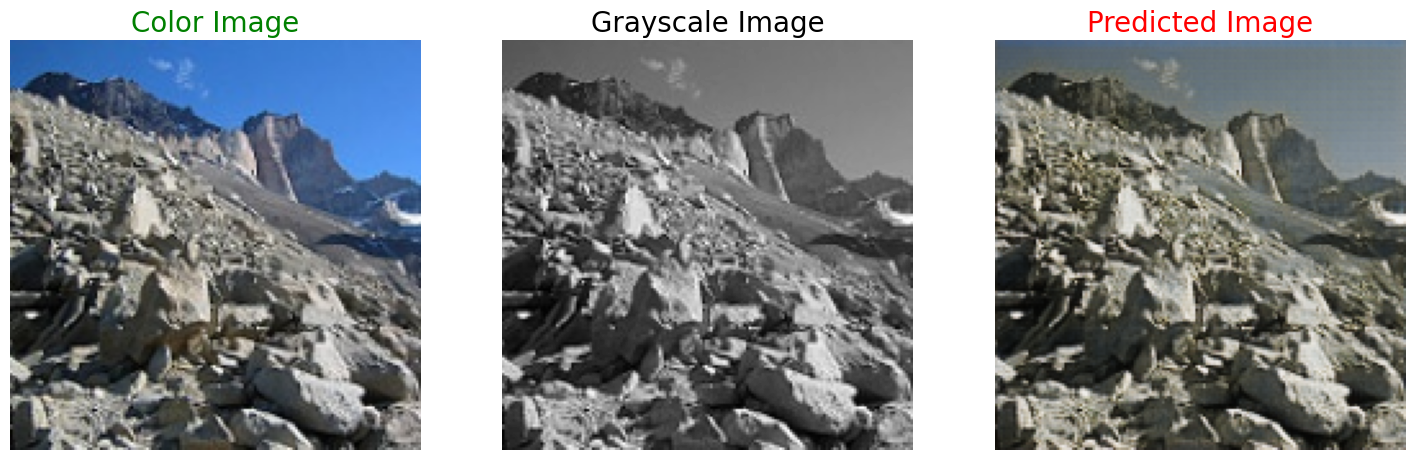

1/1 [==============================] - 0s 82ms/step


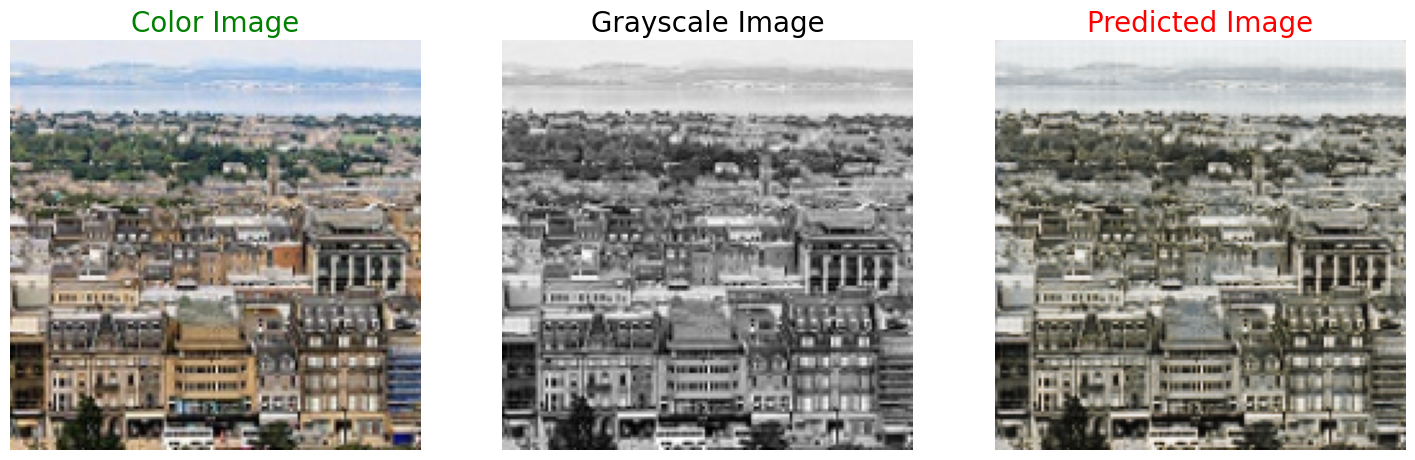

In [ ]:


# Adjust this function as needed
def plot_images(color, grayscale, predicted):
    plt.figure(figsize=(18, 6))  # Adjusted figure size for better visualization

    plt.subplot(1, 3, 1)
    plt.title('Color Image', color='green', fontsize=20)
    plt.imshow(color)
    plt.axis('off')  # Hide axes ticks

    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image', color='black', fontsize=20)
    plt.imshow(grayscale.squeeze(), cmap='gray')  # Use squeeze() to convert grayscale to 2D
    plt.axis('off')  # Hide axes ticks

    plt.subplot(1, 3, 3)
    plt.title('Predicted Image', color='red', fontsize=20)
    plt.imshow(predicted)
    plt.axis('off')  # Hide axes ticks

    plt.show()

# Generating predictions and plotting images
for i in range(50, 58):
    grayscale_input = np.expand_dims(test_gray_images[i], axis=0)  # Correct shape for model input
    predicted = model.predict(grayscale_input)
    predicted = np.clip(predicted[0], 0.0, 1.0)  # Ensure predicted image pixel values are in [0,1]

    # Convert grayscale images for plotting
    grayscale_plot = test_gray_images[i].reshape(SIZE, SIZE)

    plot_images(test_color_images[i], grayscale_plot, predicted)


# **Conclusion:**

The project has taken a significant stride in the journey of image colorization using autoencoder neural networks. The visual outcomes, as illustrated by the comparison of the original, grayscale, and predicted images, underscore the model's ability to discern and replicate patterns and structures within the grayscale input. We observe that the model has successfully reintroduced some color into the once monochromatic scene, indicating a basic grasp of the colorization task.

However, the predicted image also reveals the model's current limitations. The colors appear muted and not as diverse or accurately placed as in the original image. Such results are not uncommon in the initial phases of model training and tuning. They point to a need for further refinement of the model's architecture and training data. The application of more advanced techniques like GANs (Generative Adversarial Networks) for more sophisticated color textures, fine-tuning the model with a larger and more varied dataset, or incorporating additional context-aware layers into the neural network might yield more vibrant and true-to-life colorizations.